In [42]:
#!pip install ccxt
#!pip install python-binance
#!pip install ta
#!zip -r modeles_a_trier.zip modeles_a_trier/

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import ccxt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import signal
import sys
from keras.losses import mean_squared_error
from binance.client import Client
import matplotlib.pyplot as plt
from datetime import datetime
import ta
from ta.trend import IchimokuIndicator
import glob

def signal_handler(sig, frame):
    print('You pressed Ctrl+C!')
    os.kill(os.getpid(), 9)
    sys.exit(-888)


signal.signal(signal.SIGINT, signal_handler)


# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.expand_frame_repr', True)


def log_to_results(str_to_log):
    fr = open("results.txt", "a")
    fr.write(str_to_log + "\n")
    fr.close()

    
def cleanup_files():
    fileList = glob.glob('./modeles_a_trier/*')
    # Iterate over the list of filepaths & remove each file.
    for filePath in fileList:
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)


cleanup_files()

directory_modeles_a_trier = 'modeles_a_trier'
if not os.path.exists(directory_modeles_a_trier):
    # If it doesn't exist, create it
    os.makedirs(directory_modeles_a_trier)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # only show error messages

force_download = False

avg_predict = 0

data_history_file = "bitcoin_data_4h_01012000_05052023.pkl"
interval = Client.KLINE_INTERVAL_4HOUR

if not (os.path.exists(data_history_file)) or force_download == True:
  print("downloading data")
  # Préparer les données d'entrée
  klinesT = Client(tld='us').get_historical_klines("BTCUSDT", interval, "01 January 2000")
  #klinesT = Client().get_historical_klines("BTCUSDT", interval, "01 January 2000")
  bitcoin_data = pd.DataFrame(klinesT,
                              columns=['time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av',
                                          'trades', 'tb_base_av', 'tb_quote_av', 'ignore'])
  bitcoin_data['time'] = pd.to_datetime(bitcoin_data['time'], unit='ms')
  bitcoin_data.to_pickle(data_history_file)
else:
  print("updating data to merge to existing file with data")
  klinesT2 = Client(tld='us').get_historical_klines("BTCUSDT", interval, "1 day ago UTC")
  bitcoin_data2 = pd.DataFrame(klinesT2,
                                  columns=['time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av',
                                          'trades', 'tb_base_av', 'tb_quote_av', 'ignore'])
  bitcoin_data2['time'] = pd.to_datetime(bitcoin_data2['time'], unit='ms')
  print("loading existing file with data")
  bitcoin_data = pd.read_pickle(data_history_file)
  print("merging downloaded recent data with existing file with data")

  # remove rows from bitcoin_data2 that are already in bitcoin_data
  existing_dates = bitcoin_data['time']
  bitcoin_data2 = bitcoin_data2[~bitcoin_data2['time'].isin(existing_dates)]
  print("merging downloaded recent data with existing file with data")
  bitcoin_data = pd.concat([bitcoin_data, bitcoin_data2], ignore_index=True, sort=False)
  print("saving updated data to file")
  bitcoin_data.to_pickle(data_history_file)

# Normalisation des données d'entrée
scaler = MinMaxScaler()
# data = scaler.fit_transform(eur_usd_data[['open', 'close', 'high', 'low']].values)
data = scaler.fit_transform(bitcoin_data[['close']].values)


updating data to merge to existing file with data
loading existing file with data
merging downloaded recent data with existing file with data
merging downloaded recent data with existing file with data
saving updated data to file


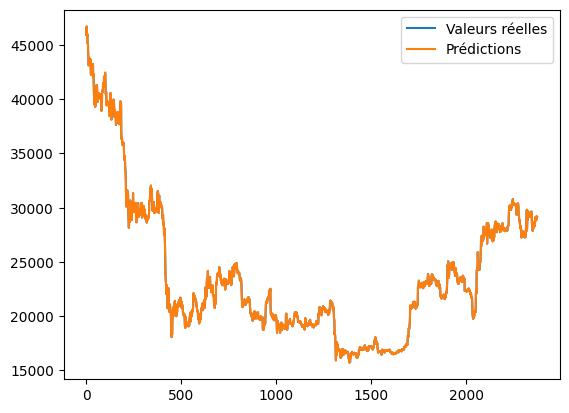

R² : 1.0
MSE : 2.9955306166595574e-33


In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Préparer les données de sortie
target_col = 'close'
target = bitcoin_data[target_col].values.reshape(-1, 1)
target = scaler.fit_transform(target)

# Fractionnement des données en ensembles de formation et de test
train_size = int(len(data) * 0.7)
train_data, test_data = data[:train_size], data[train_size:]
train_target, test_target = target[:train_size], target[train_size:]

# Créer et entraîner le modèle de régression linéaire
lr = LinearRegression()
lr.fit(train_data, train_target)

# Faire des prédictions sur les données de test
predictions = lr.predict(test_data)

# Inverser la transformation effectuée par scaler.fit_transform()
test_target_inv = scaler.inverse_transform(test_target)
predictions_inv = scaler.inverse_transform(predictions)

# Afficher les résultats avec matplotlib
plt.plot(test_target_inv, label='Valeurs réelles')
plt.plot(predictions_inv, label='Prédictions')
plt.legend()
plt.show()

# Évaluer les performances du modèle
r2 = r2_score(test_target, predictions)
mse = mean_squared_error(test_target, predictions)

print("R² :", r2)
print("MSE :", mse)


In [44]:

# Afficher la dernière valeur prédite
last_prediction = predictions_inv[-1]
print("Dernière valeur prédite :", last_prediction)


Dernière valeur prédite : [29163.08]


In [45]:
# Calculer le MSE entre les vraies valeurs et les prédictions inversées
mse_inv = mean_squared_error(test_target_inv, predictions_inv)

print("MSE (valeurs inversées) :", "{:.50f}".format(mse_inv))



MSE (valeurs inversées) : 0.00000000000000000000001331011970076905429257581843
